In [1]:
import datetime as dt
import itertools as it
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

import lenskit

from src import paths
from src.datasets import daocensus_text, to_lenskit
from src.model_selection import timeFreqSplitCurrent
from src.utils import Timer

/tmp/ipykernel_2050464/1620833652.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# TODO: Deleteme
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Parameters

In [3]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_SPLITS = 10 # Use just last 10 splits
CUTOFF_DATE_STR: str = '2023-07-29'

MDF_FILE: str = None

In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

print('CUTOFF_DATE', CUTOFF_DATE, type(CUTOFF_DATE))
# Metrics Dataframe
MDF_FILE = Path(MDF_FILE) if MDF_FILE else paths.pln_mdf(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)
print(MDF_FILE)

CUTOFF_DATE 2023-07-29 00:00:00 <class 'datetime.datetime'>
data/pln/mdf_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pkl


# Getting the dataset

In [5]:
print(ORG_NAME, ORG_PLATFORM, USE_ORG_NAMES, CUTOFF_DATE)
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfv[['voter', 'proposal']] = dfv[['voter', 'proposal']].astype(str)
dfp[['id']] = dfp[['id']].astype(str)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Decentraland snapshot True 2023-07-29 00:00:00
Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  object        
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[us]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: datetime64[us](1), float64(1), object(8)
memory usage: 8.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 8aab360f-f099-5bc0-b2e1-d1c6a46dadf

# Using Implicit MF (ALS)

Using the Conjugate Gradient method (Takacs Pilaszy 2011)

In [6]:
from lenskit.algorithms import als
from src.utils import testHParamsLenskit
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, r_precision_at_k

In [7]:
df = to_lenskit(dfv)
all_folds = list(timeFreqSplitCurrent(
    df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='user',
    item_col='item',
    user_col='user',
))
folds = all_folds[-LAST_SPLITS:]

In [8]:
metrics_f = { 
    'precision':precision_at_k, 
    'ndcg': ndcg_at_k, 
    'map': map_at_k, 
    'recall': recall_at_k,
    'r-precision': r_precision_at_k,
}

In [9]:
def testHParamsImplicitMF(fold, features: int, iterations, reg, weight, window_size=None):
    # Create algorithm
    algo = als.ImplicitMF(
        features,
        iterations=iterations,
        reg=reg,
        weight=weight,
        rng_spec=42,
    )
    return testHParamsLenskit(algo, folds[fold], K_RECOMMENDATIONS, metrics_f, window_size)
    
testHParamsImplicitMF(0, 5, 20, 0.1, 40, '14d')

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


{'time_train': 5.254237148910761,
 'time_rec': 0.08549381396733224,
 'open_proposals': 18,
 'min_recs': 1,
 'avg_recs': 9.795918367346939,
 'precision@1': 0.37755102040816324,
 'precision@3': 0.3333333333333333,
 'precision@5': 0.2857142857142857,
 'precision@10': 0.20816326530612247,
 'precision@100': 0.02612244897959184,
 'ndcg@1': 0.26618705035971224,
 'ndcg@3': 0.3160719584180466,
 'ndcg@5': 0.3566588308116534,
 'ndcg@10': 0.4047883604614254,
 'ndcg@100': 0.4603413173876901,
 'map@1': 0.37755102040816324,
 'map@3': 0.41524943310657586,
 'map@5': 0.4516468253968254,
 'map@10': 0.49740805335739735,
 'map@100': 0.5326813193404473,
 'recall@1': 0.18275024295432457,
 'recall@3': 0.44187317784256563,
 'recall@5': 0.5766520894071914,
 'recall@10': 0.7498177842565598,
 'recall@100': 1.0,
 'r-precision@1': 0.484041184041184,
 'r-precision@3': 0.7306851311953353,
 'r-precision@5': 0.7747432306255835,
 'r-precision@10': 0.8037286612758311,
 'r-precision@100': 0.8037286612758311,
 'time_eval':

## Exploring hparams

- reg: Regularization parameter. default 0.1, best searching in a logarithmic space
- features: Latent factors. 1 is equivalent to Most Popular, and more will improve personalization, but too high overfits. Nevertheless, this algorithm doesn't support a features value less than 3. I think it should be logarithmic too

In [10]:
from sklearn.model_selection import ParameterGrid
from src.model_selection import explore_hparams

In [11]:
results = explore_hparams(
    testHParamsImplicitMF, 
    ParameterGrid({
        'fold': range(len(folds)),
        'features': [4,8,16,32,64,128,],
        'reg': [1e-4,1e-1],
        'iterations': [10,20,30],
        'weight': [40],
        # 'window_size': [None],
        'window_size': ['7d', '14d', '21d', '30d', '10Y'],
    }),
    paths.mf_progress('als', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, CUTOFF_DATE),
)
mdfals = pd.DataFrame(results)
print(mdfals['fold'].value_counts())
mdfals

Restored checkpoint from data/mf/als-progress_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pickle with 3638 results


  0%|          | 0/1800 [00:00<?, ?it/s]

fold
0    180
1    180
2    180
3    180
4    180
5    180
6    180
7    180
8    180
9    180
Name: count, dtype: int64


,features,fold,iterations,reg,weight,window_size,time,open_proposals,min_recs,avg_recs,...,recall@1,recall@3,recall@5,recall@10,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@100
0,4,0,10,0.0001,40,7d,0.003773,18,3,12.038961,...,0.126747,0.384354,0.657653,0.898995,1.0,0.487976,0.664116,0.674087,0.727143,0.727143
1,4,0,10,0.0001,40,14d,0.006540,18,1,9.795918,...,0.200170,0.436492,0.526555,0.739917,1.0,0.502991,0.730906,0.784020,0.828571,0.828571
2,4,0,10,0.0001,40,21d,0.005295,18,1,10.269231,...,0.200962,0.432784,0.549153,0.745662,1.0,0.486047,0.745285,0.786703,0.818585,0.818585
3,4,0,10,0.0001,40,30d,0.008867,18,1,11.068966,...,0.197342,0.454115,0.603048,0.805952,1.0,0.487057,0.716023,0.766459,0.809221,0.809221
4,4,0,10,0.0001,40,10Y,0.220386,18,1,12.215827,...,0.123415,0.399828,0.512375,0.686220,1.0,0.439864,0.695853,0.688391,0.734676,0.738523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,128,9,30,0.1000,40,7d,3.936092,23,5,18.662162,...,0.042931,0.189820,0.317276,0.620478,1.0,0.317692,0.352335,0.396745,0.433278,0.470226
1796,128,9,30,0.1000,40,14d,3.877954,23,1,17.139785,...,0.188154,0.343321,0.493956,0.757637,1.0,0.583278,0.568112,0.589229,0.629364,0.651151
1797,128,9,30,0.1000,40,21d,3.703999,23,1,17.322917,...,0.171181,0.305947,0.414792,0.653079,1.0,0.632051,0.556451,0.581186,0.623182,0.648954
1798,128,9,30,0.1000,40,30d,4.089971,23,1,17.656863,...,0.154053,0.370348,0.493733,0.705531,1.0,0.491043,0.495683,0.531372,0.571383,0.594196


### Best overall hparams

In [12]:
_METRIC = 'map@10'

In [13]:
columns = ['time', 'avg_recs'] + [ c for c in mdfals.columns if c.endswith('@5') or c.endswith('@10') ]
params = ['features', 'reg', 'iterations', 'weight', 'window_size']
mdfals.groupby(params).mean().sort_values(_METRIC, ascending=False)[columns]

time   avg_recs  \
features reg    iterations weight window_size                        
128      0.1000 20         40     14d          2.620045  11.680062   
                30         40     14d          3.980308  11.680062   
32       0.1000 30         40     14d          1.976167  11.680062   
128      0.1000 10         40     14d          1.405873  11.680062   
64       0.1000 30         40     14d          2.075162  11.680062   
...                                                 ...        ...   
4        0.0001 10         40     10Y          0.154368  13.511534   
                20         40     10Y          0.250882  13.511534   
                30         40     10Y          0.355236  13.511534   
         0.1000 20         40     10Y          0.224864  13.511534   
                30         40     10Y          0.363087  13.511534   

                                               precision@5  precision@10  \
features reg    iterations weight window_size                              
128      0.1000 20         40     14d             0.341984      0.260166   
                30         40     14d             0.337451      0.258955   
32       0.1000 30         40     14d             0.335110      0.256812   
128      0.1000 10         40     14d             0.337255      0.259306   
64       0.1000 30         40     14d             0.342013      0.258787   
...                                                    ...           ...   
4        0.0001 10         40     10Y             0.241643      0.206439   
                20         40     10Y             0.241299      0.205580   
                30         40     10Y             0.241421      0.205313   
         0.1000 20         40     10Y             0.240900      0.205703   
                30         40     10Y             0.242521      0.205118   

                                                 ndcg@5   ndcg@10     map@5  \
features reg    iterations weight window_size                                 
128      0.1000 20         40     14d          0.352053  0.411787  0.452148   
                30         40     14d          0.348031  0.409017  0.448348   
32       0.1000 30         40     14d          0.352541  0.411019  0.448469   
128      0.1000 10         40     14d          0.346030  0.409026  0.443789   
64       0.1000 30         40     14d          0.348294  0.405688  0.447469   
...                                                 ...       ...       ...   
4        0.0001 10         40     10Y          0.364033  0.462378  0.302116   
                20         40     10Y          0.363366  0.460355  0.301715   
                30         40     10Y          0.362731  0.459970  0.301393   
         0.1000 20         40     10Y          0.360267  0.459318  0.299635   
                30         40     10Y          0.362930  0.458738  0.301331   

                                                 map@10  recall@5  recall@10  \
features reg    iterations weight window_size                                  
128      0.1000 20         40     14d          0.505760  0.577910   0.830006   
                30         40     14d          0.502179  0.569398   0.823212   
32       0.1000 30         40     14d          0.501679  0.560433   0.811925   
128      0.1000 10         40     14d          0.501180  0.568887   0.829024   
64       0.1000 30         40     14d          0.498745  0.567326   0.811490   
...                                                 ...       ...        ...   
4        0.0001 10         40     10Y          0.357896  0.418081   0.687843   
                20         40     10Y          0.356485  0.417539   0.684638   
                30         40     10Y          0.355984  0.416568   0.685056   
         0.1000 20         40     10Y          0.355076  0.412319   0.685969   
                30         40     10Y          0.355031  0.418077   0.683079   

                                               r-precision@5  r-precision@10  
fea

### Best hparams per fold

In [14]:
print("Best hyperparams by fold", _METRIC)
_df = mdfals.sort_values(_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', *params])[columns]
_df

Best hyperparams by fold map@10


,,,,,,time,avg_recs,precision@5,precision@10,ndcg@5,ndcg@10,map@5,map@10,recall@5,recall@10,r-precision@5,r-precision@10
fold,features,reg,iterations,weight,window_size,,,,,,,,,,,,
0,32,0.1000,30,40,14d,1.647454,9.795918,0.306122,0.220408,0.419523,0.472917,0.531236,0.575203,0.642031,0.852612,0.726228,0.767668
1,128,0.1000,30,40,21d,3.926506,18.208955,0.398507,0.341045,0.365779,0.413471,0.410230,0.433887,0.358988,0.592720,0.510815,0.643555
2,8,0.0001,20,40,14d,0.005547,11.462366,0.288172,0.234409,0.390410,0.465463,0.450726,0.504151,0.557642,0.850733,0.708904,0.785712
3,32,0.1000,30,40,14d,2.283285,8.246753,0.425974,0.302597,0.485338,0.557258,0.557045,0.631553,0.671015,0.906100,0.691547,0.729293
4,128,0.1000,10,40,14d,1.341889,7.939024,0.434146,0.295122,0.480643,0.526738,0.628018,0.677589,0.751147,0.938618,0.754345,0.809425
5,4,0.1000,20,40,14d,0.024163,10.884615,0.392308,0.287179,0.340029,0.382223,0.505972,0.552876,0.584830,0.798579,0.665760,0.725474
6,128,0.1000,20,40,14d,2.532576,10.388350,0.320388,0.224272,0.419762,0.478241,0.539962,0.590717,0.681859,0.916297,0.785216,0.820056
7,32,0.0001,20,40,14d,1.448923,6.666667,0.393333,0.231667,0.391642,0.429151,0.630069,0.675334,0.823056,1.000000,0.806746,0.810714
8,4,0.1000,10,40,14d,0.003956,16.557143,0.278571,0.251429,0.218794,0.269539,0.319796,0.373964,0.396205,0.661501,0.523515,0.639795


## Plotting some graphs

<Axes: xlabel='features', ylabel='map@10'>

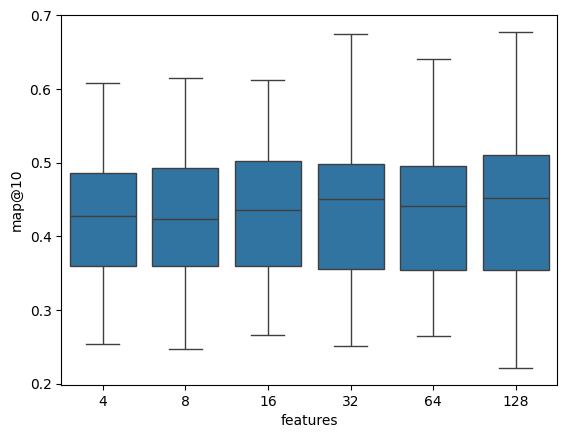

In [15]:
sns.boxplot(mdfals, y=_METRIC, x='features')

# Using SVD

A traditional SVD using scikit-learn's [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [16]:
from lenskit.algorithms import svd

In [17]:
def testHParamsImplicitSVD(fold, features, damping=5, window_size=None):
    # Create algorithm
    algo = svd.BiasedSVD(
        features,
        damping=damping,
        bias=True,
        algorithm='randomized'
    )
    return testHParamsLenskit(algo, folds[fold], K_RECOMMENDATIONS, metrics_f, window_size)
    
testHParamsImplicitSVD(0, 40, window_size='14d')

self.explained_variance_ratio_ = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] / 0.0


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py:276: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


{'time_train': 0.14343249495141208,
 'time_rec': 0.13257610402069986,
 'open_proposals': 18,
 'min_recs': 1,
 'avg_recs': 9.795918367346939,
 'precision@1': 0.42857142857142855,
 'precision@3': 0.35714285714285715,
 'precision@5': 0.28775510204081634,
 'precision@10': 0.22653061224489798,
 'precision@100': 0.02612244897959184,
 'ndcg@1': 0.302158273381295,
 'ndcg@3': 0.3447910616003309,
 'ndcg@5': 0.36970117781587014,
 'ndcg@10': 0.4458607006478975,
 'ndcg@100': 0.478579702031515,
 'map@1': 0.42857142857142855,
 'map@3': 0.44869614512471656,
 'map@5': 0.47458616780045354,
 'map@10': 0.539359473097629,
 'map@100': 0.5626329357817846,
 'recall@1': 0.21352040816326529,
 'recall@3': 0.4772959183673469,
 'recall@5': 0.5670068027210885,
 'recall@10': 0.855818756073858,
 'recall@100': 1.0,
 'r-precision@1': 0.49821428571428567,
 'r-precision@3': 0.7140909090909091,
 'r-precision@5': 0.7845454545454545,
 'r-precision@10': 0.8231079931972788,
 'r-precision@100': 0.823107993197279,
 'time_eval':

## Exploring hparams

- Features: Latent space size
- Damping: The damping values can be interpreted as the number of default (mean) ratings to assume
    *a priori* for each user or item, damping low-information users and items towards a mean instead
    of permitting them to take on extreme values based on few ratings.

In [18]:
results = explore_hparams(
    testHParamsImplicitSVD, 
    ParameterGrid({
        'fold': range(len(folds)),
        'features': [1,2,4,8,16,],
        'damping': [0,1,2,3,4,5,10,15],
        'window_size': ['7d', '14d', '21d', '30d', '10Y'],
    }),
    paths.mf_progress('svd', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, CUTOFF_DATE),
)
mdfsvd = pd.DataFrame(results)
mdfsvd

Restored checkpoint from data/mf/svd-progress_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pickle with 2320 results


  0%|          | 0/2000 [00:00<?, ?it/s]

,damping,features,fold,window_size,time,open_proposals,min_recs,avg_recs,precision@1,precision@3,...,recall@1,recall@3,recall@5,recall@10,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@100
0,1,4,0,7d,0.006356,18,3,12.038961,0.129870,0.129870,...,0.058983,0.152056,0.349892,0.880999,1.0,0.454167,0.458333,0.531439,0.592857,0.592857
1,1,4,0,14d,0.004722,18,1,9.795918,0.428571,0.357143,...,0.213520,0.477296,0.567007,0.855819,1.0,0.498214,0.714091,0.784545,0.823108,0.823108
2,1,4,0,21d,0.005688,18,1,10.269231,0.413462,0.342949,...,0.206010,0.457772,0.542308,0.825675,1.0,0.498256,0.703655,0.771637,0.809093,0.809093
3,1,4,0,30d,0.007430,18,1,11.068966,0.379310,0.313218,...,0.189009,0.416882,0.492672,0.793422,1.0,0.498295,0.692514,0.758192,0.794623,0.794623
4,1,4,0,10Y,0.114704,18,1,12.215827,0.323741,0.273381,...,0.158287,0.351489,0.422732,0.773291,1.0,0.488932,0.667048,0.719731,0.764548,0.768153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,16,9,7d,0.004371,23,5,18.662162,0.391892,0.247748,...,0.215068,0.329074,0.397208,0.652052,1.0,0.548794,0.546287,0.548714,0.578451,0.591255
1996,0,16,9,14d,0.014214,23,1,17.139785,0.430108,0.268817,...,0.238308,0.368556,0.458797,0.698737,1.0,0.554066,0.572610,0.584847,0.619459,0.637270
1997,0,16,9,21d,0.013275,23,1,17.322917,0.427083,0.267361,...,0.232944,0.361205,0.448626,0.686277,1.0,0.545430,0.569353,0.581604,0.615609,0.633108
1998,0,16,9,30d,0.014643,23,1,17.656863,0.421569,0.267974,...,0.232313,0.360320,0.444106,0.681478,1.0,0.551069,0.565836,0.580036,0.615594,0.633207


### Best overall hparams

In [19]:
columns = ['time', 'avg_recs'] + [ c for c in mdfals.columns if c.endswith('@5') or c.endswith('@10') ]
params = ['features', 'damping', 'window_size']
mdfsvd.groupby(params).mean().sort_values(_METRIC, ascending=False)[columns]

time   avg_recs  precision@5  precision@10  \
features damping window_size                                                   
4        3       14d          0.004338  11.680062     0.333774      0.255931   
2        0       14d          0.004197  11.680062     0.333774      0.255931   
         15      14d          0.004384  11.680062     0.333774      0.255931   
         3       14d          0.004315  11.680062     0.333774      0.255931   
4        10      14d          0.004440  11.680062     0.333774      0.255931   
...                                ...        ...          ...           ...   
8        4       10Y          0.076019  13.511534     0.272129      0.220695   
         5       10Y          0.074918  13.511534     0.272129      0.220695   
         10      10Y          0.083676  13.511534     0.272129      0.220695   
         15      10Y          0.081854  13.511534     0.272129      0.220695   
4        4       10Y          0.097171  13.511534     0.272129      0.220695   

                                ndcg@5   ndcg@10     map@5    map@10  \
features damping window_size                                           
4        3       14d          0.354608  0.413268  0.449530  0.503965   
2        0       14d          0.354608  0.413268  0.449530  0.503965   
         15      14d          0.354608  0.413268  0.449530  0.503965   
         3       14d          0.354608  0.413268  0.449530  0.503965   
4        10      14d          0.354608  0.413268  0.449530  0.503965   
...                                ...       ...       ...       ...   
8        4       10Y          0.431788  0.530400  0.361755  0.416600   
         5       10Y          0.431788  0.530400  0.361755  0.416600   
         10      10Y          0.431788  0.530400  0.361755  0.416600   
         15      10Y          0.431788  0.530400  0.361755  0.416600   
4        4       10Y          0.431788  0.530400  0.361755  0.416600   

                              recall@5  recall@10  r-precision@5  \
features damping window_size                                       
4        3       14d          0.560719   0.808969       0.646880   
2        0       14d          0.560719   0.808969       0.646880   
         15      14d          0.560719   0.808969       0.646880   
         3       14d          0.560719   0.808969       0.646880   
4        10      14d          0.560719   0.808969       0.646880   
...                                ...        ...            ...   
8        4       10Y          0.480236   0.761999       0.607418   
         5       10Y          0.480236   0.761999       0.607418   
         10      10Y          0.480236   0.761999       0.607418   
         15      10Y          0.480236   0.761999       0.607418   
4        4       10Y          0.480236   0.761999       0.607418   

                              r-precision@10  
features damping window_size                  
4        3       14d                0.706386  
2        0       14d                0.706386  
         15      14d                0.706386  
         3       14d                0.706386  
4        10      14d                0.706386  
...                                      ...  
8        4       10Y                0.663924  
         5       10Y                0.663924  
         10      10Y                0.663924  
         15      10Y                0.663924  
4        4       10Y                0.663924  

[200 rows x 12 columns]

### Best hparams per fold

In [20]:
print("Best hyperparams by fold", _METRIC)
_df = mdfsvd.sort_values(_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', *params])[columns]
_df

Best hyperparams by fold map@10


,,,,time,avg_recs,precision@5,precision@10,ndcg@5,ndcg@10,map@5,map@10,recall@5,recall@10,r-precision@5,r-precision@10
fold,features,damping,window_size,,,,,,,,,,,,
0,8,2,14d,0.004825,9.795918,0.287755,0.226531,0.369701,0.445861,0.474586,0.539359,0.567007,0.855819,0.784545,0.823108
1,2,3,14d,0.004331,17.720000,0.436800,0.363200,0.370005,0.408579,0.420642,0.450526,0.449013,0.647980,0.491904,0.636269
2,8,15,14d,0.004726,11.462366,0.290323,0.223656,0.389868,0.449714,0.440227,0.486283,0.581443,0.814673,0.691991,0.767880
3,2,2,14d,0.004244,8.246753,0.438961,0.303896,0.484828,0.553015,0.551147,0.615615,0.694608,0.928394,0.661932,0.692614
4,1,15,14d,0.003756,7.939024,0.392683,0.289024,0.418708,0.485172,0.521928,0.588428,0.638516,0.910264,0.655208,0.713478
5,4,15,14d,0.003897,10.884615,0.364103,0.273077,0.299894,0.343113,0.426581,0.480163,0.538025,0.741298,0.637484,0.715878
6,2,5,14d,0.004061,10.388350,0.306796,0.223301,0.421099,0.482250,0.538954,0.593028,0.670028,0.907902,0.729356,0.759793
7,1,1,14d,0.003943,6.666667,0.336667,0.231667,0.296549,0.365128,0.450699,0.526119,0.673056,1.000000,0.751562,0.756771
8,1,10,14d,0.004687,16.557143,0.260000,0.237857,0.201855,0.249546,0.290222,0.336051,0.336699,0.584623,0.479968,0.578612


## Plotting some graphs

<Axes: xlabel='fold', ylabel='map@10'>

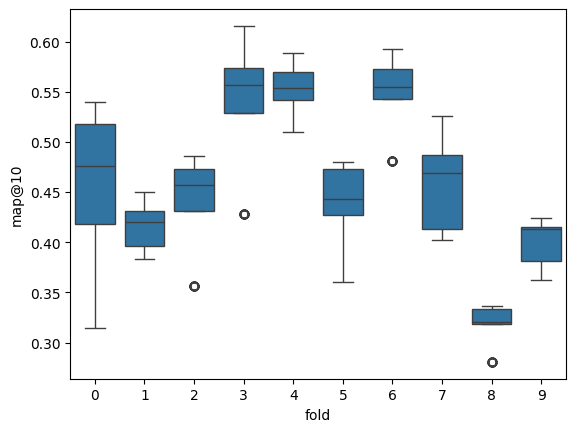

In [21]:
sns.boxplot(mdfsvd, y=_METRIC, x='fold')

<Axes: xlabel='window_size', ylabel='map@10'>

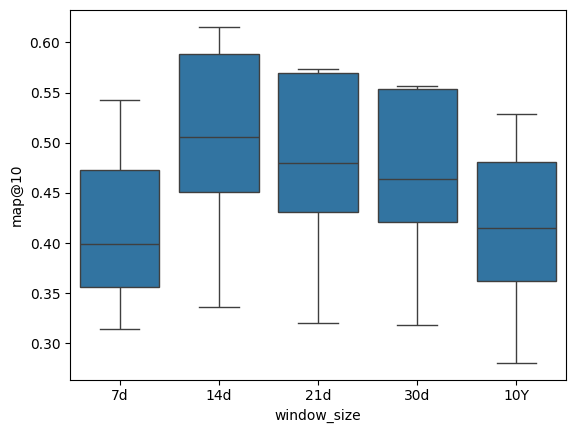

In [22]:
sns.boxplot(mdfsvd, y=_METRIC, x='window_size')

<Axes: xlabel='features', ylabel='map@10'>

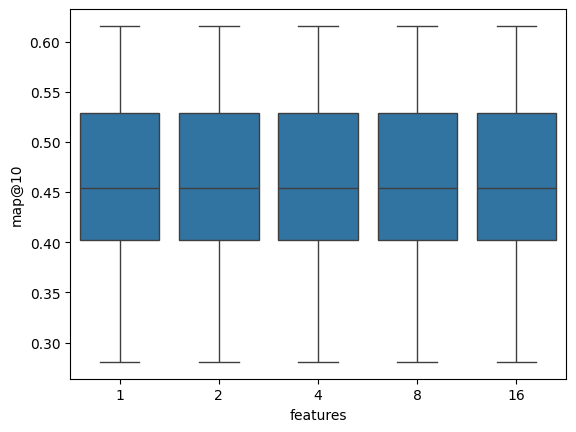

In [23]:
sns.boxplot(mdfsvd, y=_METRIC, x='features')

<Axes: xlabel='damping', ylabel='map@10'>

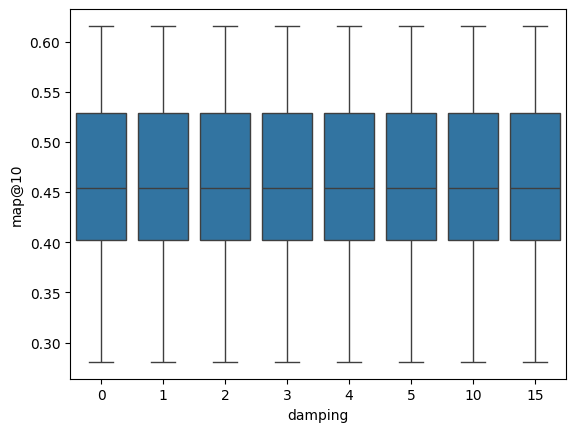

In [24]:
sns.boxplot(mdfsvd, y=_METRIC, x='damping')